In [1]:
import numpy as np
from scipy.spatial.distance import euclidean as d_eucli
import pywt

from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation


time_series=np.fromfile("seismic_size50k_len256_znorm.bin", dtype=np.float32).reshape(-1, 256)





In [2]:
def reconstruction_error(orig, reconstructed):
    return d_eucli(orig, reconstructed)

def list_reconstruction_error(list_orig, list_reconstruct):
    errors = []
    for i in range(len(list_orig)):
        errors.append(reconstruction_error(list_orig[i], list_reconstruct[i]))
    return errors

# Wavelets reduction

C'est le plus compliqué des trois methodes à comprendre, ça nécessite de la compréhension en traitement de signal, son application par contre est simple, quelque lien de quelques tutos un peu compliqué du coup:
http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
la partie interessante est la 3.3 sur le tuto

In [11]:


def wavelet_reduction(ts, reduction_length=8):
        coeffs = pywt.wavedec(ts, 'db1')
        coeffs = pywt.coeffs_to_array(coeffs)
        return coeffs[0][:reduction_length], coeffs[1]

def list_wavelet_reduction(time_series, reduction_length=8):
    reduced = []
    for ts in time_series:
        red , sliced = wavelet_reduction(ts, reduction_length)
        reduced.append(red)
    
    return reduced, sliced
    
    
        
def wavelet_reconstruction(reduced_ts, sliced, reduced_length=8, original_length=256):
    reduced = np.pad(reduced_ts, (0, int(original_length - reduced_length)),  'constant')
    coeffs = pywt.array_to_coeffs(reduced, sliced, output_format='wavedec')
    return pywt.waverec(coeffs, 'db1')

def list_wavelet_reconstruction(reduced_timeseries, sliced, reduced_length=8, original_length=256):
    reconst = []
    for ts in reduced_timeseries:
        reconst.append(wavelet_reconstruction(ts, sliced, reduced_length, original_length))
    return reconst

In [12]:
w_reduced_ts_8b, sliced_8b = list_wavelet_reduction(time_series, reduction_length=8)
w_reconstructed_ts_8b = list_wavelet_reconstruction(w_reduced_ts_8b, sliced_8b, reduced_length=8)
w_list_error_8b = list_reconstruction_error(time_series, w_reconstructed_ts_8b)
print("average error with 8 point reduction", np.average(w_list_error_8b))

average error with 8 point reduction 15.978650000133515


In [13]:
w_reduced_ts_16b, sliced_16b = list_wavelet_reduction(time_series, reduction_length=16)
w_reconstructed_ts_16b = list_wavelet_reconstruction(w_reduced_ts_16b, sliced_16b, reduced_length=16)
w_list_error_16b = list_reconstruction_error(time_series, w_reconstructed_ts_16b)
print("average error with 16 point reduction", np.average(w_list_error_16b))

average error with 16 point reduction 15.946925214729308


In [14]:
w_reduced_ts_32b, sliced_32b = list_wavelet_reduction(time_series, reduction_length=32)
w_reconstructed_ts_32b = list_wavelet_reconstruction(w_reduced_ts_32b, sliced_32b, reduced_length=32)
w_list_error_32b = list_reconstruction_error(time_series, w_reconstructed_ts_32b)
print("average error with 32 point reduction", np.average(w_list_error_32b))

average error with 32 point reduction 15.8094279406929


# PCA Reduction:

In [7]:
sc = StandardScaler()
X_std = sc.fit_transform(time_series)


In [8]:
pca_8b = PCA(n_components=8)
X_pca_8b = pca_8b.fit_transform(X_std)
reconst_pca_8b = pca_8b.inverse_transform(X_pca_8b)
pca_all_reconst_errors_8b = list_reconstruction_error(X_std, reconst_pca_8b)
print("average reconstruction error PCA from 256 to 8 dimensions : ", np.average(pca_all_reconst_errors_8b))

average reconstruction error PCA from 256 to 8 dimensions :  15.467802508201599


In [9]:
pca_16b = PCA(n_components=16)
X_pca_16b = pca_16b.fit_transform(X_std)
reconst_pca_16b = pca_16b.inverse_transform(X_pca_16b)
pca_all_reconst_errors_16b = list_reconstruction_error(X_std, reconst_pca_16b)
print("average reconstruction error PCA from 256 to 16 dimensions : ", np.average(pca_all_reconst_errors_16b))

average reconstruction error PCA from 256 to 16 dimensions :  14.925177841796875


In [10]:
pca_32b = PCA(n_components=32)
X_pca_32b = pca_32b.fit_transform(X_std)
reconst_pca_32b = pca_32b.inverse_transform(X_pca_32b)
pca_all_reconst_errors_32b = list_reconstruction_error(X_std, reconst_pca_32b)
print("average reconstruction error PCA from 256 to 32 dimensions : ", np.average(pca_all_reconst_errors_32b))

average reconstruction error PCA from 256 to 32 dimensions :  13.836157926387786


# Paa Reduction:
Le plus simple à comprendre c'est juste de faire des moyennes de chaque case une à une, y'a une version amelioré de ça qui va un peu plus loin (qui fait des moyennes de moyennes), voila le paper de celui-ci : <
https://www.cs.ucr.edu/~eamonn/kais_2000.pdf
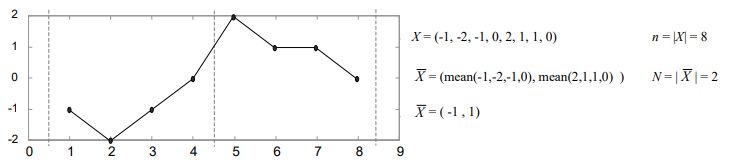

In [7]:
def preprocessing_ts_to_paa(time_serie,size_word):

    size_letter = int(len(time_serie) / size_word)
    step = size_letter
    weights = [1.0] * size_letter

    modulo = len(time_serie) % size_word
    overtaking = 0

    if modulo != 0:

        size_letter += 1
        overtaking = (len(time_serie) % size_word) / len(time_serie)
        weights.append(overtaking)

    len_time_serie = len(time_serie)
    return len_time_serie, modulo, step, weights, overtaking, size_letter

def loop_ts_to_paa(time_serie, len_time_serie, modulo, step, weights, overtaking, size_letter):

    paa_word = []
    for i in range(0, len_time_serie - modulo, step):
        start = i
        end = i + size_letter
        paa_letter = np.average(time_serie[start:end], weights=weights)
        paa_word.append(paa_letter)
        if overtaking != 0:
            weights[0] -= overtaking
            weights[-1] += overtaking

    return paa_word

def ts_to_paa(time_serie,size_word):
    len_time_serie, modulo, step, weights, overtaking, size_letter = preprocessing_ts_to_paa(time_serie, size_word)
    return loop_ts_to_paa(time_serie, len_time_serie, modulo, step, weights, overtaking, size_letter)

def paa_to_ts(paa_time_serie, segment_size):
    original_ts = []
    for i in paa_time_serie:
        for j in range(int(segment_size)):
            original_ts.append(i)
            
    return original_ts

def list_paa_to_ts(list_paa_ts, segment_size):
    list_ts =[]
    for i in range(len(list_paa_ts)):
        list_ts.append(paa_to_ts(list_paa_ts[i], segment_size))
        
    return list_ts

def list_ts_to_list_paa(list_time_serie,size_word):
    list_paa = []
    len_time_serie, modulo, step, weights, overtaking, size_letter = preprocessing_ts_to_paa(list_time_serie[0], size_word)
    for i in range(len(list_time_serie)):
        list_paa.append( loop_ts_to_paa(list_time_serie[i], len_time_serie, modulo, step, weights, overtaking, size_letter) )
    return list_paa


def reconstruction_error(orig, reconstructed):
    return d_eucli(orig, reconstructed)

def list_reconstruction_error(list_orig, list_reconstruct):
    errors = []
    for i in range(len(list_orig)):
        errors.append(reconstruction_error(list_orig[i], list_reconstruct[i]))
    return errors

In [8]:
time_series_reduced_32b=list_ts_to_list_paa(time_series, size_word=int(256/(1024/32)))
time_series_reduced_64b=list_ts_to_list_paa(time_series, size_word=int(256/(1024/64)))
time_series_reduced_128b=list_ts_to_list_paa(time_series,size_word=int(256/(1024/128)))

In [9]:
time_series_reconst_32b=list_paa_to_ts(time_series_reduced_32b, segment_size=256/len(time_series_reduced_32b[0]))
time_series_reconst_64b=list_paa_to_ts(time_series_reduced_64b, segment_size=256/len(time_series_reduced_64b[0]))
time_series_reconst_128b=list_paa_to_ts(time_series_reduced_128b, segment_size=256/len(time_series_reduced_128b[0]))

In [10]:
all_recont_errors_32b = list_reconstruction_error(time_series, time_series_reconst_32b)
all_recont_errors_64b = list_reconstruction_error(time_series, time_series_reconst_64b)
all_recont_errors_128b = list_reconstruction_error(time_series, time_series_reconst_128b)

In [16]:
print("average reconstruction error PAA from 256 to 8 dimensions : ", np.average(all_recont_errors_32b))
print("average reconstruction error PAA from 256 to 16 dimensions : ", np.average(all_recont_errors_64b))
print("average reconstruction error PAA from 256 to 32 dimensions : ", np.average(all_recont_errors_128b))

average reconstruction error PAA from 256 to 8 dimensions :  15.97864999776946
average reconstruction error PAA from 256 to 16 dimensions :  15.946925214890312
average reconstruction error PAA from 256 to 32 dimensions :  15.809427941404719


50000
50000


'seismic_size50k_len256_znorm.bin_sum128_rec128'